# ADS 509 Team 1 Project - Tesla vs Toyota News Articles
### By: Jesse Gutierrez, Roger Qiu, Shailja Somani

link: https://newsapi.org/

newsapi key: d6995599193044b0a5f954c098da84d6

## Part 1. API retrival, pre-processing and EDA

### Install and add imports

In [137]:
from newsapi import NewsApiClient
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
import regex as re
from datetime import datetime, timedelta
import nltk
from textblob import TextBlob
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.pipeline import Pipeline
nltk.download('stopwords')

from collections import Counter

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


### Check the newsAPI data source

In [138]:
# use API key to initialize newsapi client
newsapi = NewsApiClient(api_key='d6995599193044b0a5f954c098da84d6')
newsapi

In [139]:
# check what the top headlines data looks like
top_headlines = newsapi.get_top_headlines(q='world',
                                          category='business',
                                          language='en',
                                          country='us')

top_headlines                                    

{'status': 'ok',
 'totalResults': 3,
 'articles': [{'source': {'id': None, 'name': 'WSBT-TV'},
   'author': 'JAMIE SCOTT | WJLA Staff',
   'title': "World's longest serving flight attendant dies at age 88 - KOMO News",
   'description': 'Bette Nash flew for almost 67 years, joining Eastern Airlines back in 1957, when flights cost $12 and required no reservations.',
   'url': 'https://wsbt.com/news/nation-world/worlds-longest-serving-flight-attendant-dies-at-age-88-bette-nash-american-airlines-eastern-airlines-manassas-virginia-ronald-reagan-airport-dca-boston-new-york-hospice-care-recent-breast-cancer-diagnosis',
   'urlToImage': 'https://komonews.com/resources/media/467d0fcd-4b61-4c5b-8ff2-6fc52c5d17c1-large16x9_Screenshot20240525at6.36.07PM.png',
   'publishedAt': '2024-05-25T22:54:25Z',
   'content': 'WASHINGTON (WJLA) Bette Nash flew for almost 67 years, joining Eastern Airlines back in 1957, when flights cost $12 and required no reservations.\r\nHer role at Eastern eventually brou

In [140]:
# check all the available news sources
sources = newsapi.get_sources()

# check first 3
sources['sources'][:3]

[{'id': 'abc-news',
  'name': 'ABC News',
  'description': 'Your trusted source for breaking news, analysis, exclusive interviews, headlines, and videos at ABCNews.com.',
  'url': 'https://abcnews.go.com',
  'category': 'general',
  'language': 'en',
  'country': 'us'},
 {'id': 'abc-news-au',
  'name': 'ABC News (AU)',
  'description': "Australia's most trusted source of local, national and world news. Comprehensive, independent, in-depth analysis, the latest business, sport, weather and more.",
  'url': 'https://www.abc.net.au/news',
  'category': 'general',
  'language': 'en',
  'country': 'au'},
 {'id': 'aftenposten',
  'name': 'Aftenposten',
  'description': 'Norges ledende nettavis med alltid oppdaterte nyheter innenfor innenriks, utenriks, sport og kultur.',
  'url': 'https://www.aftenposten.no',
  'category': 'general',
  'language': 'no',
  'country': 'no'}]

### Retrieve and download Toyota and Tesla related articles

In [141]:
# Please feel free to delete, but this elimates the need to update the date
# This is helpful as we can only pull data from w/in 29 days

# Get today's date
today = datetime.today()

# Calculate date 29 days ago
twentynine_days_ago = today - timedelta(days=29)

# Format dates in the required format (YYYY-MM-DD)
from_date = twentynine_days_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

# Get Toyota news text data
toyota_raw = newsapi.get_everything(
    q='toyota',
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page=5
)

# Display the first 3 articles
toyota_articles = toyota_raw['articles'][:3]
for article in toyota_articles:
    print(article['title'], article['description'])

Original-Owner 1982 DeLorean DMC-12 This 1982 DeLorean DMC-12 was purchased new by the seller from Pat Thomas Toyota in Fargo, North Dakota, and it now shows 8k miles. The car is powered by a 2.85-liter V6 paired with a five-speed manual transaxle and features unfinished stainless steel body pa…
[Removed] [Removed]
Toyota Boshoku America’s Solar Power Venture This partnership marks TBA’s largest on-site solar project to date, aligning with their goal to eliminate the impact of carbon emissions from their facilities.


In [143]:
# convert the json into a df
df = pd.DataFrame(toyota_raw['articles'])
df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Bringatrailer.com'}",bringatrailer,Original-Owner 1982 DeLorean DMC-12,This 1982 DeLorean DMC-12 was purchased new by...,https://bringatrailer.com/listing/1982-delorea...,https://bringatrailer.com/wp-content/uploads/2...,2024-05-23T16:35:16Z,This 1982 DeLorean DMC-12 was purchased new by...
1,"{'id': None, 'name': '[Removed]'}",None,[Removed],[Removed],https://removed.com,None,1970-01-01T00:00:00Z,[Removed]
2,"{'id': None, 'name': 'Environmentenergyleader....",Staff Writer,Toyota Boshoku America’s Solar Power Venture,This partnership marks TBA’s largest on-site s...,https://www.environmentenergyleader.com/2024/0...,https://www.environmentenergyleader.com/wp-con...,2024-05-08T14:30:37Z,"Toyota Boshoku, a leading global interior syst..."
3,"{'id': None, 'name': 'Minneapolis Star Tribune'}",YURI KAGEYAMA,"Toyota racks up booming profit, vows to invest...",Toyota doubled its net profit in the fiscal ye...,https://www.startribune.com/toyota-racks-up-bo...,https://www.startribune.com/static/img/brandin...,2024-05-08T06:34:00Z,TOKYO Toyota doubled its net profit in the fis...
4,"{'id': None, 'name': 'AutoExpress'}",Ellis Hyde,Car Deal of the Day: petrol-sipping Toyota Yar...,The effortlessly fuel efficient hybrid SUV is ...,https://www.autoexpress.co.uk/toyota/yaris/363...,https://media.autoexpress.co.uk/image/private/...,2024-05-02T15:46:06Z,<ul><li>Hybrid SUV capable of 64.1mpg</li><li>...


In [144]:
# create a data folder to store the csv data
if not os.path.exists('data/toyota'):
    os.makedirs('data/toyota')

In [145]:
# download the toyota text data to data folder
df.to_csv('data/toyota/data.csv', index=False)

In [146]:
# Please feel free to delete, but this elimates the need to update the date
# This is helpful as we can only pull data from w/in 29 days

# Get today's date
today = datetime.today()

# Format dates in the required format (YYYY-MM-DD)
from_date = twentynine_days_ago.strftime('%Y-%m-%d')
to_date = today.strftime('%Y-%m-%d')

# Get Toyota news text data
tesla_raw = newsapi.get_everything(
    q='tesla',
    from_param=from_date,
    to=to_date,
    language='en',
    sort_by='relevancy',
    page=5
)

# Display the first 3 articles
tesla_articles = tesla_raw['articles'][:3]
for article in tesla_articles:
    print(article['title'], article['description'])

Family of doctor who drove kids off California cliff say he has schizoaffective disorder Dharmesh Patel's wife and young children miraculously survived the January 2, 2023 crash off Highway 1 between Pacifica and Half Moon Bay.
Musk Passes Bezos As Richest American Again As Tesla Stock Soars Tesla’s share price is 30% higher than it was just six days ago, ahead of its first-quarter earnings report.
U.S. loosens battery rules, potentially making more cars eligible for EV tax credits Filed under:
 Government/Legal,Green,Plants/Manufacturing,Electric
 Continue reading U.S. loosens battery rules, potentially making more cars eligible for EV tax credits
U.S. loosens battery rules, potentially making more cars eligible for EV tax credits orig…


### read in and intial transformations

In [148]:
# read in the data
raw_tesla = pd.read_csv('data/tesla/data.csv')
raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Ozbargain.com.au'}",Bippz01,"Tesla Model 3 Performance $82,700 Delivered + ...",These are the website prices for QLD personal ...,https://www.ozbargain.com.au/node/842643,https://files.ozbargain.com.au/n/43/842643x.jp...,2024-04-24T05:55:43Z,These are the website prices for QLD personal ...
1,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Why is Tesla FSD a Big Deal Even Before Robotaxi?,Every Tesla FSD sale even with the price cuts ...,https://www.nextbigfuture.com/2024/04/why-is-t...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-04-29T16:51:23Z,Every Tesla FSD sale even with the price cuts ...
2,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Did Elon Cut Tesla Supercharging as a Power Move?,There has been a lot of speculation about why ...,https://www.nextbigfuture.com/2024/05/did-elon...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-05-04T21:13:42Z,There has been a lot of speculation about why ...
3,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,"Tesla Still Sells More EVs In USA Than Ford, C...","Actually, wait, Tesla still sells more electri...",https://cleantechnica.com/2024/05/04/tesla-sti...,https://cleantechnica.com/wp-content/uploads/2...,2024-05-05T03:57:07Z,Sign up for daily news updates from CleanTechn...
4,"{'id': None, 'name': 'The Indian Express'}","Sonal Gupta, Ayesha Jain",Daily Briefing: Delhi Congress chief resigns; ...,In today’s edition: A Lok Sabha election wrap;...,https://indianexpress.com/article/live-news/da...,https://images.indianexpress.com/2024/04/cover...,2024-04-29T03:34:48Z,"In mounting trouble for Congress, its Delhi ch..."


In [149]:
# 100 records with 8 fields
raw_tesla.shape

(100, 8)

In [150]:
# read the CSV file again
raw_toyota = pd.read_csv('data/toyota/data.csv')
raw_toyota.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': None, 'name': 'Bringatrailer.com'}",bringatrailer,Original-Owner 1982 DeLorean DMC-12,This 1982 DeLorean DMC-12 was purchased new by...,https://bringatrailer.com/listing/1982-delorea...,https://bringatrailer.com/wp-content/uploads/2...,2024-05-23T16:35:16Z,This 1982 DeLorean DMC-12 was purchased new by...
1,"{'id': None, 'name': '[Removed]'}",NaN,[Removed],[Removed],https://removed.com,NaN,1970-01-01T00:00:00Z,[Removed]
2,"{'id': None, 'name': 'Environmentenergyleader....",Staff Writer,Toyota Boshoku America’s Solar Power Venture,This partnership marks TBA’s largest on-site s...,https://www.environmentenergyleader.com/2024/0...,https://www.environmentenergyleader.com/wp-con...,2024-05-08T14:30:37Z,"Toyota Boshoku, a leading global interior syst..."
3,"{'id': None, 'name': 'Minneapolis Star Tribune'}",YURI KAGEYAMA,"Toyota racks up booming profit, vows to invest...",Toyota doubled its net profit in the fiscal ye...,https://www.startribune.com/toyota-racks-up-bo...,https://www.startribune.com/static/img/brandin...,2024-05-08T06:34:00Z,TOKYO Toyota doubled its net profit in the fis...
4,"{'id': None, 'name': 'AutoExpress'}",Ellis Hyde,Car Deal of the Day: petrol-sipping Toyota Yar...,The effortlessly fuel efficient hybrid SUV is ...,https://www.autoexpress.co.uk/toyota/yaris/363...,https://media.autoexpress.co.uk/image/private/...,2024-05-02T15:46:06Z,<ul><li>Hybrid SUV capable of 64.1mpg</li><li>...


In [151]:
# also 100 records and 8 fields
raw_toyota.shape

(100, 8)

In [152]:
# check how the title looks
raw_tesla['title'][0]

'Tesla Model 3 Performance $82,700 Delivered + on-Road Costs @ Tesla'

In [153]:
# check how content looks
raw_tesla['content'][0]

'These are the website prices for QLD personal use.\r\nThe PERFORMANCE version has been relaunched.All-new high-performance drive units deliver a combined 460 horsepower and 0-100 km/h in 3.1 seconds. W… [+204 chars]'

In [154]:
# check how the description looks
raw_tesla['description'][0]

# descriptions gives more information than content field.
# so title and description are the 2 fields we can use to combine into a new "text" field.

'These are the website prices for QLD personal use.\n\nThe PERFORMANCE version has been relaunched.\nAll-new high-performance drive units deliver a combined 460 horsepower and 0-100 km/h in 3.1 seconds. Welcome to the most powerful Model 3 ever.\n\n528 km Range (WL…'

In [155]:
# label both df's and then union into 1 df with 200 records
raw_tesla['label'] = 'tesla'
raw_toyota['label'] = 'toyota'

raw_tesla.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label
0,"{'id': None, 'name': 'Ozbargain.com.au'}",Bippz01,"Tesla Model 3 Performance $82,700 Delivered + ...",These are the website prices for QLD personal ...,https://www.ozbargain.com.au/node/842643,https://files.ozbargain.com.au/n/43/842643x.jp...,2024-04-24T05:55:43Z,These are the website prices for QLD personal ...,tesla
1,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Why is Tesla FSD a Big Deal Even Before Robotaxi?,Every Tesla FSD sale even with the price cuts ...,https://www.nextbigfuture.com/2024/04/why-is-t...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-04-29T16:51:23Z,Every Tesla FSD sale even with the price cuts ...,tesla
2,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Did Elon Cut Tesla Supercharging as a Power Move?,There has been a lot of speculation about why ...,https://www.nextbigfuture.com/2024/05/did-elon...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-05-04T21:13:42Z,There has been a lot of speculation about why ...,tesla
3,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,"Tesla Still Sells More EVs In USA Than Ford, C...","Actually, wait, Tesla still sells more electri...",https://cleantechnica.com/2024/05/04/tesla-sti...,https://cleantechnica.com/wp-content/uploads/2...,2024-05-05T03:57:07Z,Sign up for daily news updates from CleanTechn...,tesla
4,"{'id': None, 'name': 'The Indian Express'}","Sonal Gupta, Ayesha Jain",Daily Briefing: Delhi Congress chief resigns; ...,In today’s edition: A Lok Sabha election wrap;...,https://indianexpress.com/article/live-news/da...,https://images.indianexpress.com/2024/04/cover...,2024-04-29T03:34:48Z,"In mounting trouble for Congress, its Delhi ch...",tesla


In [156]:
# union
combined = pd.concat([raw_tesla, raw_toyota], axis=0, ignore_index=True)
combined.shape

(200, 9)

In [157]:
# concat title with description to create text field
combined['text'] = combined['title'] + ' ' + combined['description']
combined['text'][0]

'Tesla Model 3 Performance $82,700 Delivered + on-Road Costs @ Tesla These are the website prices for QLD personal use.\n\nThe PERFORMANCE version has been relaunched.\nAll-new high-performance drive units deliver a combined 460 horsepower and 0-100 km/h in 3.1 seconds. Welcome to the most powerful Model 3 ever.\n\n528 km Range (WL…'

In [158]:
# check another example
combined['text'][105]

'New Omoda 7 plug-in hybrid SUV arriving in 2025 to take on Toyota RAV4 The new mid-size SUV from China will also be going up against the best-selling Hyundai Tucson and Kia Sportage'

In [159]:
# add a length field to check text lengths
combined['length'] = combined['text'].str.len()
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length
0,"{'id': None, 'name': 'Ozbargain.com.au'}",Bippz01,"Tesla Model 3 Performance $82,700 Delivered + ...",These are the website prices for QLD personal ...,https://www.ozbargain.com.au/node/842643,https://files.ozbargain.com.au/n/43/842643x.jp...,2024-04-24T05:55:43Z,These are the website prices for QLD personal ...,tesla,"Tesla Model 3 Performance $82,700 Delivered + ...",328.0
1,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Why is Tesla FSD a Big Deal Even Before Robotaxi?,Every Tesla FSD sale even with the price cuts ...,https://www.nextbigfuture.com/2024/04/why-is-t...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-04-29T16:51:23Z,Every Tesla FSD sale even with the price cuts ...,tesla,Why is Tesla FSD a Big Deal Even Before Robota...,310.0
2,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Did Elon Cut Tesla Supercharging as a Power Move?,There has been a lot of speculation about why ...,https://www.nextbigfuture.com/2024/05/did-elon...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-05-04T21:13:42Z,There has been a lot of speculation about why ...,tesla,Did Elon Cut Tesla Supercharging as a Power Mo...,310.0
3,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,"Tesla Still Sells More EVs In USA Than Ford, C...","Actually, wait, Tesla still sells more electri...",https://cleantechnica.com/2024/05/04/tesla-sti...,https://cleantechnica.com/wp-content/uploads/2...,2024-05-05T03:57:07Z,Sign up for daily news updates from CleanTechn...,tesla,"Tesla Still Sells More EVs In USA Than Ford, C...",370.0
4,"{'id': None, 'name': 'The Indian Express'}","Sonal Gupta, Ayesha Jain",Daily Briefing: Delhi Congress chief resigns; ...,In today’s edition: A Lok Sabha election wrap;...,https://indianexpress.com/article/live-news/da...,https://images.indianexpress.com/2024/04/cover...,2024-04-29T03:34:48Z,"In mounting trouble for Congress, its Delhi ch...",tesla,Daily Briefing: Delhi Congress chief resigns; ...,237.0


### 

<Figure size 800x600 with 0 Axes>

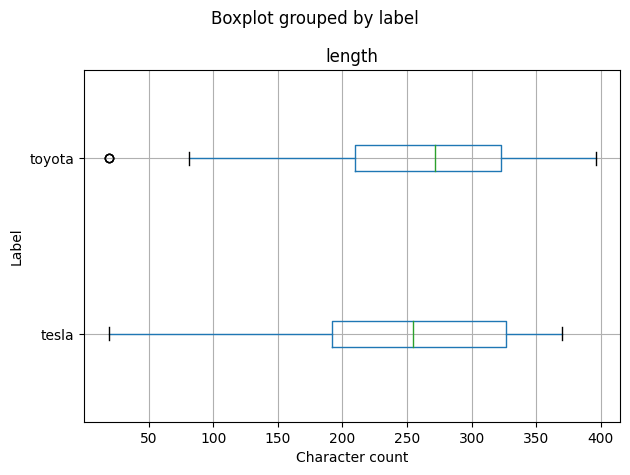

In [160]:
# crete boxplot to see distribution of counts by label
plt.figure(figsize=(8, 6))
combined.boxplot(column='length', by='label', vert=False)
plt.xlabel('Character count')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

### clean and process text

In [161]:
# define function to tokenize text
def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [162]:
# check stopwords
stopwords = set(nltk.corpus.stopwords.words('english'))
list(stopwords)[:5]

['any', 'won', "isn't", 'mightn', "needn't"]

In [163]:
# add tesla and toyota as stopwords, we do not want to see these words in the features
include_stopwords = {'tesla', 'toyota'}
stopwords |= include_stopwords

In [164]:
# define function to remove stopwords
def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

In [165]:
# create pipeline to lowercase, tokenize and remove stop words
pipeline = [str.lower, tokenize, remove_stop]

# define function to feed text data through the pipeline and return cleaned tokens
def prepare(text, pipeline):

  # convert text to string if it's not already a string (for float types)
  text = str(text)

  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return tokens

In [166]:
combined['tokens'] = combined['text'].apply(prepare, pipeline=pipeline)
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'Ozbargain.com.au'}",Bippz01,"Tesla Model 3 Performance $82,700 Delivered + ...",These are the website prices for QLD personal ...,https://www.ozbargain.com.au/node/842643,https://files.ozbargain.com.au/n/43/842643x.jp...,2024-04-24T05:55:43Z,These are the website prices for QLD personal ...,tesla,"Tesla Model 3 Performance $82,700 Delivered + ...",328.0,"[model, performance, delivered, on-road, costs..."
1,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Why is Tesla FSD a Big Deal Even Before Robotaxi?,Every Tesla FSD sale even with the price cuts ...,https://www.nextbigfuture.com/2024/04/why-is-t...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-04-29T16:51:23Z,Every Tesla FSD sale even with the price cuts ...,tesla,Why is Tesla FSD a Big Deal Even Before Robota...,310.0,"[fsd, big, deal, even, robotaxi, every, fsd, s..."
2,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Did Elon Cut Tesla Supercharging as a Power Move?,There has been a lot of speculation about why ...,https://www.nextbigfuture.com/2024/05/did-elon...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-05-04T21:13:42Z,There has been a lot of speculation about why ...,tesla,Did Elon Cut Tesla Supercharging as a Power Mo...,310.0,"[elon, cut, supercharging, power, move, lot, s..."
3,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,"Tesla Still Sells More EVs In USA Than Ford, C...","Actually, wait, Tesla still sells more electri...",https://cleantechnica.com/2024/05/04/tesla-sti...,https://cleantechnica.com/wp-content/uploads/2...,2024-05-05T03:57:07Z,Sign up for daily news updates from CleanTechn...,tesla,"Tesla Still Sells More EVs In USA Than Ford, C...",370.0,"[still, sells, evs, usa, ford, chevrolet, hyun..."
4,"{'id': None, 'name': 'The Indian Express'}","Sonal Gupta, Ayesha Jain",Daily Briefing: Delhi Congress chief resigns; ...,In today’s edition: A Lok Sabha election wrap;...,https://indianexpress.com/article/live-news/da...,https://images.indianexpress.com/2024/04/cover...,2024-04-29T03:34:48Z,"In mounting trouble for Congress, its Delhi ch...",tesla,Daily Briefing: Delhi Congress chief resigns; ...,237.0,"[daily, briefing, delhi, congress, chief, resi..."


In [167]:
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens
0,"{'id': None, 'name': 'Ozbargain.com.au'}",Bippz01,"Tesla Model 3 Performance $82,700 Delivered + ...",These are the website prices for QLD personal ...,https://www.ozbargain.com.au/node/842643,https://files.ozbargain.com.au/n/43/842643x.jp...,2024-04-24T05:55:43Z,These are the website prices for QLD personal ...,tesla,"Tesla Model 3 Performance $82,700 Delivered + ...",328.0,"[model, performance, delivered, on-road, costs..."


In [168]:
# get the number of tokens as a field
combined['num_tokens'] = combined['tokens'].map(len)
combined[:1]

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'Ozbargain.com.au'}",Bippz01,"Tesla Model 3 Performance $82,700 Delivered + ...",These are the website prices for QLD personal ...,https://www.ozbargain.com.au/node/842643,https://files.ozbargain.com.au/n/43/842643x.jp...,2024-04-24T05:55:43Z,These are the website prices for QLD personal ...,tesla,"Tesla Model 3 Performance $82,700 Delivered + ...",328.0,"[model, performance, delivered, on-road, costs...",30


### EDA and visualizations

In [169]:
# seperate records based on labels in 2 different series
tesla_tokens = combined.loc[combined['label'] == 'tesla', 'tokens']
toyota_tokens = combined.loc[combined['label'] == 'toyota', 'tokens']

tesla_tokens[:5]

0    [model, performance, delivered, on-road, costs...
1    [fsd, big, deal, even, robotaxi, every, fsd, s...
2    [elon, cut, supercharging, power, move, lot, s...
3    [still, sells, evs, usa, ford, chevrolet, hyun...
4    [daily, briefing, delhi, congress, chief, resi...
Name: tokens, dtype: object

In [170]:
# flatten each so we can get all tokens in each df into a single list
tesla_flat_tokens = [word for sublist in tesla_tokens for word in sublist]
toyota_flat_tokens = [word for sublist in toyota_tokens for word in sublist]

tesla_flat_tokens[:5]

['model', 'performance', 'delivered', 'on-road', 'costs']

In [171]:
# 2828 tokens
len(tesla_flat_tokens)

1777

In [172]:
# get count of each word 
tesla_word_counts = Counter(tesla_flat_tokens)
toyota_word_counts = Counter(toyota_flat_tokens)

# check the first 5 records
dict(list(tesla_word_counts.items())[:5])

{'model': 21, 'performance': 9, 'delivered': 3, 'on-road': 4, 'costs': 2}

In [173]:
# get the 10 most common words for both each
print(tesla_word_counts.most_common(10))

[('nan', 28), ('fsd', 23), ('musk', 23), ('model', 21), ('elon', 18), ('china', 18), ('new', 13), ('car', 12), ('autopilot', 11), ('year', 10)]


In [174]:
print(toyota_word_counts.most_common(10))

[('car', 42), ('new', 36), ('first', 22), ('hybrid', 19), ('cars', 19), ('tour', 18), ('electric', 15), ('us', 12), ('vehicles', 10), ('martin', 10)]


In [175]:
# convert counter type to list so we can plot
top_tesla_words = list(tesla_word_counts.most_common(10))
top_toyota_words = list(toyota_word_counts.most_common(10))

In [176]:
# get words and their count from the list
tesla_words, tesla_counts = zip(*top_tesla_words)
toyota_words, toyota_counts = zip(*top_toyota_words)

print(tesla_words)
print(tesla_counts)

('nan', 'fsd', 'musk', 'model', 'elon', 'china', 'new', 'car', 'autopilot', 'year')
(28, 23, 23, 21, 18, 18, 13, 12, 11, 10)


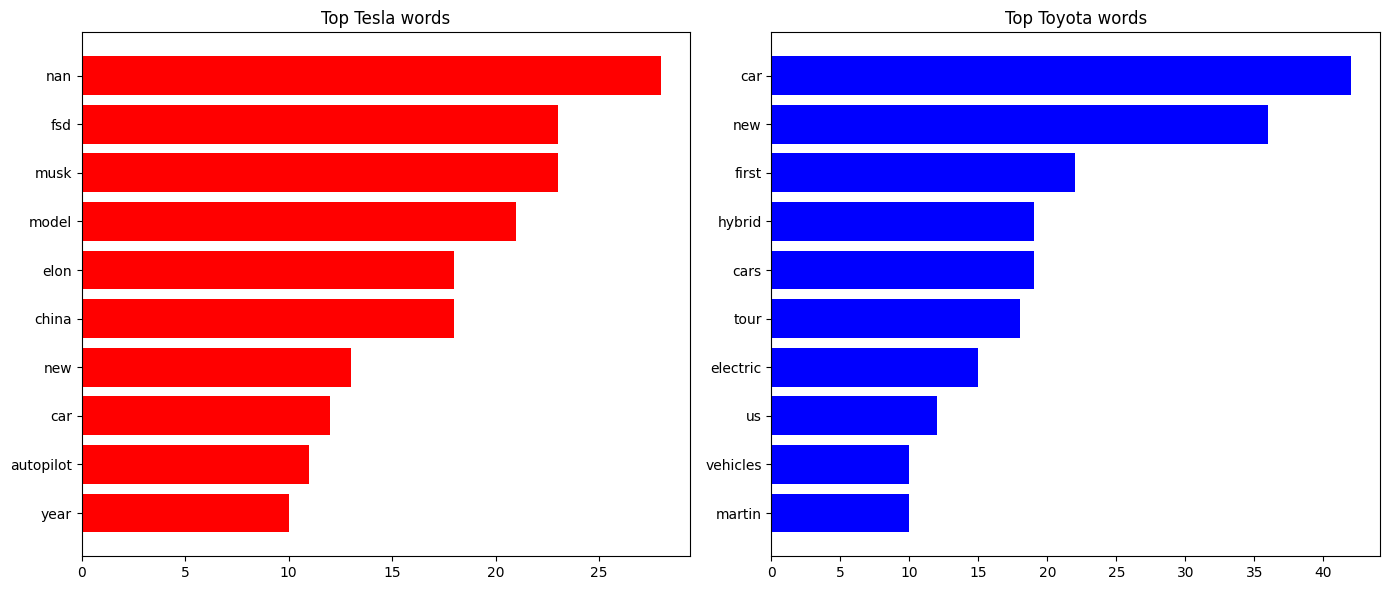

In [177]:
# create 2 subplots, next to eachother
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# plot tesla words, highest counts at the top
ax[0].barh(tesla_words, tesla_counts, color='red')
ax[0].invert_yaxis()
ax[0].set_title('Top Tesla words')

# do the same for toyota
ax[1].barh(toyota_words, toyota_counts, color='blue')
ax[1].invert_yaxis()  # Highest counts at the top
ax[1].set_title('Top Toyota words')

# show the plot, tight layout so fit is better
plt.tight_layout()
plt.show()

In [178]:
# now to get the descriptive statistics, define the function created in earlier assignments
def descriptive_stats(tokens, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # length of num tokens list
    num_tokens = len(tokens)

    # length of unique tokens in list
    num_unique_tokens = len(set(tokens))

    # unique tokens divided by total tokens to see diversity
    lexical_diversity = num_unique_tokens / num_tokens

    # get sum of characters
    sum = 0
    for word in tokens:
        for char in word:
            sum += 1

    num_characters = sum
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [179]:
# Split the DataFrame based on the "label" field
tesla_df = combined[combined['label'] == 'tesla']
toyota_df = combined[combined['label'] == 'toyota']

# Combine all the lists in the "tokens" field into one giant list for each DataFrame
tesla_tokens = [item for sublist in tesla_df['tokens'] for item in sublist]
toyota_tokens = [item for sublist in toyota_df['tokens'] for item in sublist]

In [180]:
tesla_tokens[:5]

['model', 'performance', 'delivered', 'on-road', 'costs']

In [181]:
# apply descriptive stats to the tesla tokens
descriptive_stats(tesla_tokens)

There are 1777 tokens in the data.
There are 991 unique tokens in the data.
There are 10657 characters in the data.
The lexical diversity is 0.558 in the data.


[1777, 991, 0.5576814856499719, 10657]

In [182]:
# do the same for toyota
descriptive_stats(toyota_tokens)

There are 2673 tokens in the data.
There are 1501 unique tokens in the data.
There are 15895 characters in the data.
The lexical diversity is 0.562 in the data.


[2673, 1501, 0.5615413393191171, 15895]

## Part 2: Classification Models

In [183]:
combined.head()

,source,author,title,description,url,urlToImage,publishedAt,content,label,text,length,tokens,num_tokens
0,"{'id': None, 'name': 'Ozbargain.com.au'}",Bippz01,"Tesla Model 3 Performance $82,700 Delivered + ...",These are the website prices for QLD personal ...,https://www.ozbargain.com.au/node/842643,https://files.ozbargain.com.au/n/43/842643x.jp...,2024-04-24T05:55:43Z,These are the website prices for QLD personal ...,tesla,"Tesla Model 3 Performance $82,700 Delivered + ...",328.0,"[model, performance, delivered, on-road, costs...",30
1,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Why is Tesla FSD a Big Deal Even Before Robotaxi?,Every Tesla FSD sale even with the price cuts ...,https://www.nextbigfuture.com/2024/04/why-is-t...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-04-29T16:51:23Z,Every Tesla FSD sale even with the price cuts ...,tesla,Why is Tesla FSD a Big Deal Even Before Robota...,310.0,"[fsd, big, deal, even, robotaxi, every, fsd, s...",32
2,"{'id': 'next-big-future', 'name': 'Next Big Fu...",Brian Wang,Did Elon Cut Tesla Supercharging as a Power Move?,There has been a lot of speculation about why ...,https://www.nextbigfuture.com/2024/05/did-elon...,https://nextbigfuture.s3.amazonaws.com/uploads...,2024-05-04T21:13:42Z,There has been a lot of speculation about why ...,tesla,Did Elon Cut Tesla Supercharging as a Power Mo...,310.0,"[elon, cut, supercharging, power, move, lot, s...",26
3,"{'id': None, 'name': 'CleanTechnica'}",Zachary Shahan,"Tesla Still Sells More EVs In USA Than Ford, C...","Actually, wait, Tesla still sells more electri...",https://cleantechnica.com/2024/05/04/tesla-sti...,https://cleantechnica.com/wp-content/uploads/2...,2024-05-05T03:57:07Z,Sign up for daily news updates from CleanTechn...,tesla,"Tesla Still Sells More EVs In USA Than Ford, C...",370.0,"[still, sells, evs, usa, ford, chevrolet, hyun...",36
4,"{'id': None, 'name': 'The Indian Express'}","Sonal Gupta, Ayesha Jain",Daily Briefing: Delhi Congress chief resigns; ...,In today’s edition: A Lok Sabha election wrap;...,https://indianexpress.com/article/live-news/da...,https://images.indianexpress.com/2024/04/cover...,2024-04-29T03:34:48Z,"In mounting trouble for Congress, its Delhi ch...",tesla,Daily Briefing: Delhi Congress chief resigns; ...,237.0,"[daily, briefing, delhi, congress, chief, resi...",28


In [184]:
# First want to create a sentiment analyzes between the two automanufacturers

# Split the DataFrame into two groups based on the presence of "Tesla" or "Toyota"
tesla_df = combined[combined['title'].str.contains('Tesla', case=False, na=False)]
toyota_df = combined[combined['title'].str.contains('Toyota', case=False, na=False)]

# Define a function to handle sentiment analysis, with a check for non-string values
def analyze_sentiment(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return None

# Apply the sentiment analysis function, handling non-string values
tesla_df['sentiment'] = tesla_df['description'].apply(analyze_sentiment)
toyota_df['sentiment'] = toyota_df['description'].apply(analyze_sentiment)

# Function to calculate statistics
def calculate_stats(df):
    valid_sentiments = df['sentiment'].dropna()
    sentiment_range = valid_sentiments.max() - valid_sentiments.min()
    sentiment_min = valid_sentiments.min()
    sentiment_max = valid_sentiments.max()
    sentiment_median = valid_sentiments.median()
    sentiment_mean = valid_sentiments.mean()
    return sentiment_range, sentiment_min, sentiment_max, sentiment_median, sentiment_mean

# Calculate stats for Tesla
tesla_range, tesla_min, tesla_max, tesla_median, tesla_mean = calculate_stats(tesla_df)
# Calculate stats for Toyota
toyota_range, toyota_min, toyota_max, toyota_median, toyota_mean = calculate_stats(toyota_df)

# Display the results
print("Tesla DataFrame:")
tesla_df
print(f"Sentiment Range: {tesla_range}, Min: {tesla_min}, Max: {tesla_max}, Median: {tesla_median}, Mean: {tesla_mean}")

print("\nToyota DataFrame:")
toyota_df
print(f"Sentiment Range: {toyota_range}, Min: {toyota_min}, Max: {toyota_max}, Median: {toyota_median}, Mean: {toyota_mean}")

Tesla DataFrame:
Sentiment Range: 0.9625, Min: -0.15, Max: 0.8125, Median: 0.09999999999999999, Mean: 0.11403746018132813

Toyota DataFrame:
Sentiment Range: 0.4790404040404041, Min: -0.03333333333333338, Max: 0.4457070707070707, Median: 0.13636363636363635, Mean: 0.13163131313131313


/var/folders/gy/c9ysryks527gqrvc9m2d1pn80000gn/T/ipykernel_2572/2068336896.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tesla_df['sentiment'] = tesla_df['description'].apply(analyze_sentiment)
/var/folders/gy/c9ysryks527gqrvc9m2d1pn80000gn/T/ipykernel_2572/2068336896.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toyota_df['sentiment'] = toyota_df['description'].apply(analyze_sentiment)


In [185]:
# Want to see class balance between the two manufacturers
print(combined['label'].value_counts())

tesla     100
toyota    100
Name: label, dtype: int64


Logistic Regression:
Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

       Tesla       0.89      1.00      0.94        17
      Toyota       0.00      0.00      0.00         2

    accuracy                           0.89        19
   macro avg       0.45      0.50      0.47        19
weighted avg       0.80      0.89      0.85        19

Confusion matrix, without normalization
[[17  0]
 [ 2  0]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

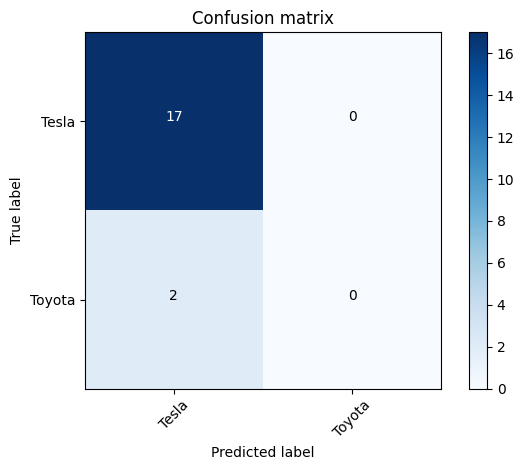

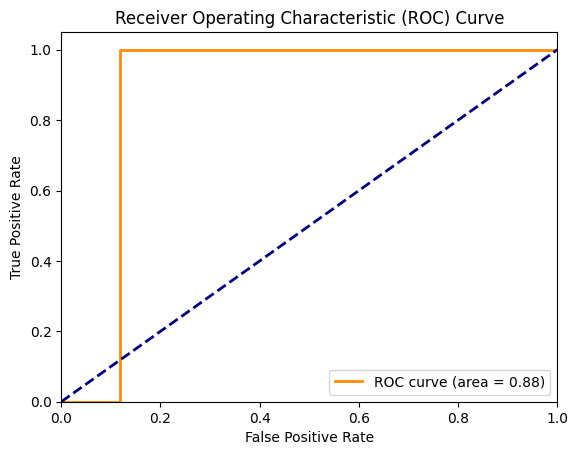


Support Vector Machine:
Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

       Tesla       0.89      1.00      0.94        17
      Toyota       0.00      0.00      0.00         2

    accuracy                           0.89        19
   macro avg       0.45      0.50      0.47        19
weighted avg       0.80      0.89      0.85        19

Confusion matrix, without normalization
[[17  0]
 [ 2  0]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

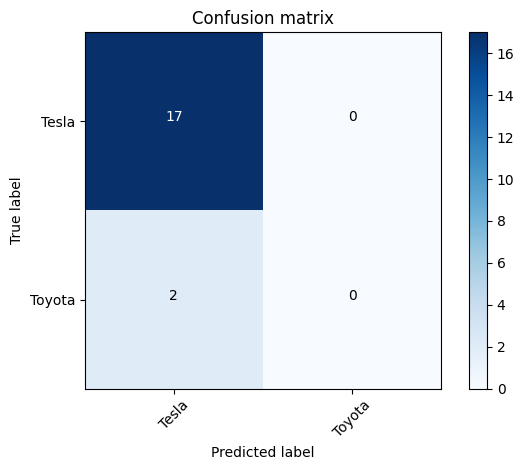

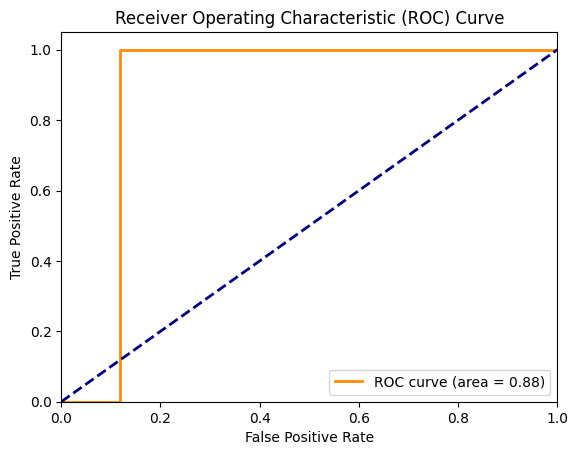


Random Forest:
Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

       Tesla       0.89      1.00      0.94        17
      Toyota       0.00      0.00      0.00         2

    accuracy                           0.89        19
   macro avg       0.45      0.50      0.47        19
weighted avg       0.80      0.89      0.85        19

Confusion matrix, without normalization
[[17  0]
 [ 2  0]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

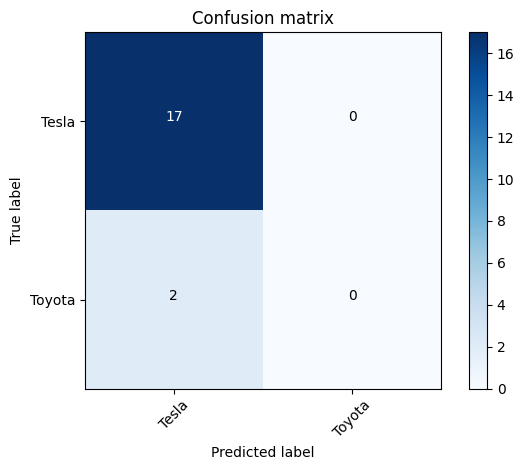

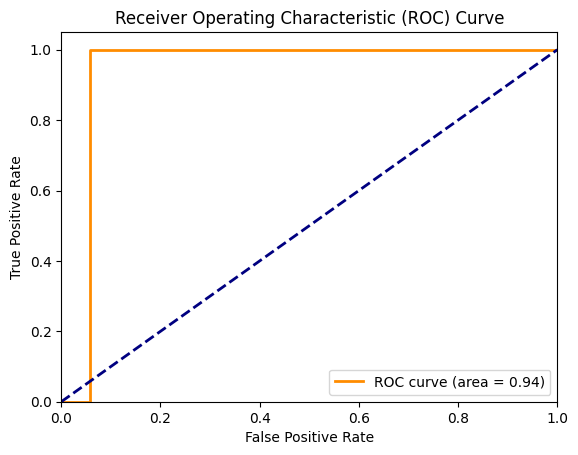


Naive Bayes:
Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

       Tesla       0.89      1.00      0.94        17
      Toyota       0.00      0.00      0.00         2

    accuracy                           0.89        19
   macro avg       0.45      0.50      0.47        19
weighted avg       0.80      0.89      0.85        19

Confusion matrix, without normalization
[[17  0]
 [ 2  0]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

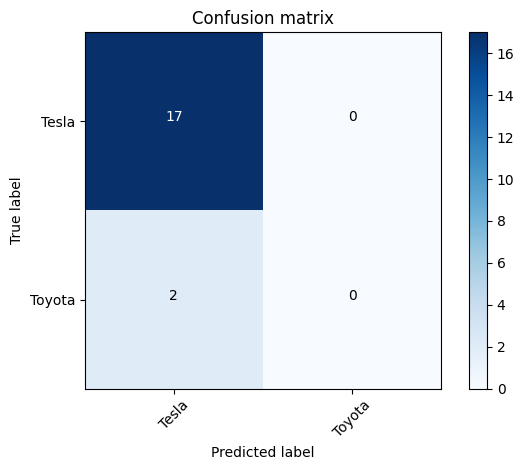

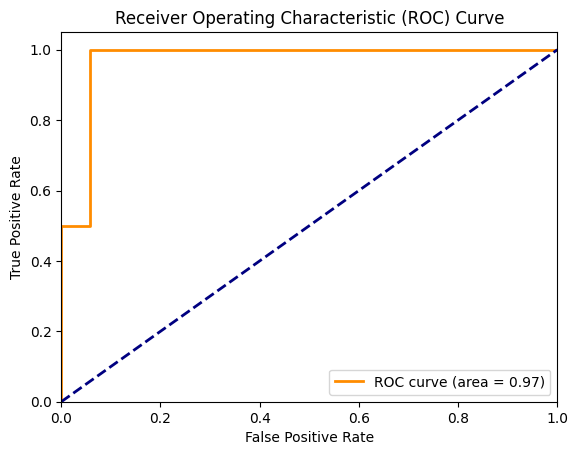


K-Nearest Neighbors:
Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

       Tesla       0.89      1.00      0.94        17
      Toyota       0.00      0.00      0.00         2

    accuracy                           0.89        19
   macro avg       0.45      0.50      0.47        19
weighted avg       0.80      0.89      0.85        19

Confusion matrix, without normalization
[[17  0]
 [ 2  0]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

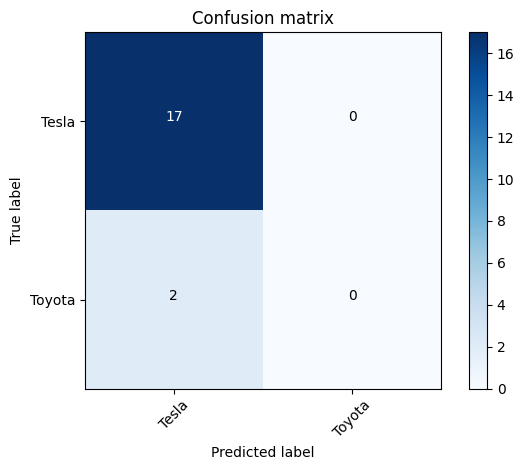

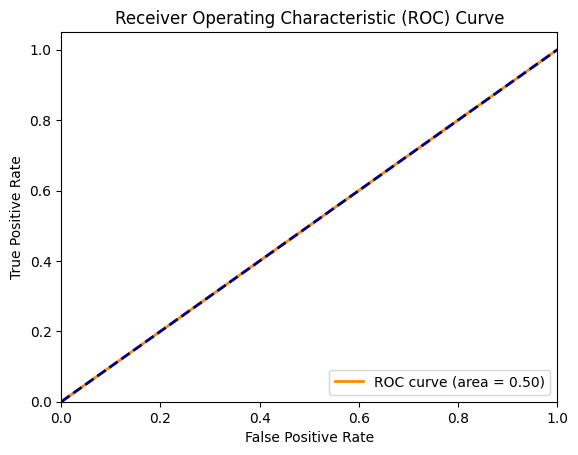


Gradient Boosting:
Accuracy: 0.9473684210526315
              precision    recall  f1-score   support

       Tesla       0.94      1.00      0.97        17
      Toyota       1.00      0.50      0.67         2

    accuracy                           0.95        19
   macro avg       0.97      0.75      0.82        19
weighted avg       0.95      0.95      0.94        19

Confusion matrix, without normalization
[[17  0]
 [ 1  1]]


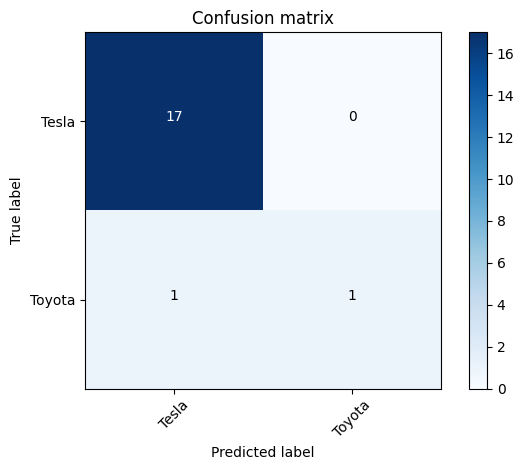

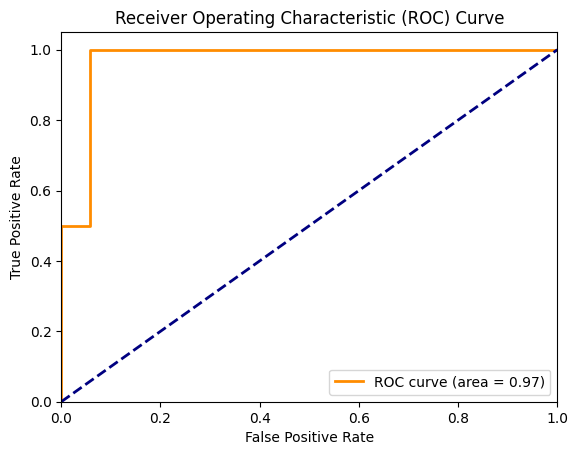


AdaBoost:
Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

       Tesla       0.94      0.94      0.94        17
      Toyota       0.50      0.50      0.50         2

    accuracy                           0.89        19
   macro avg       0.72      0.72      0.72        19
weighted avg       0.89      0.89      0.89        19

Confusion matrix, without normalization
[[16  1]
 [ 1  1]]


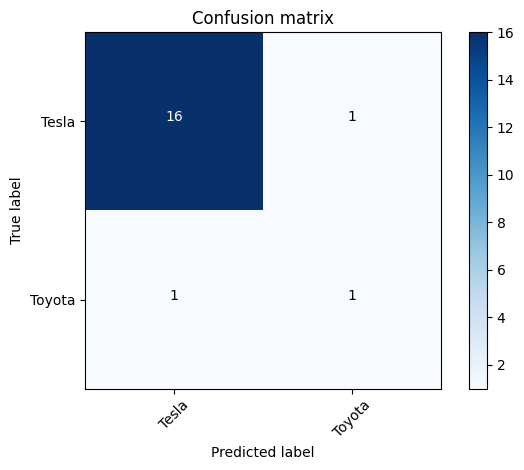

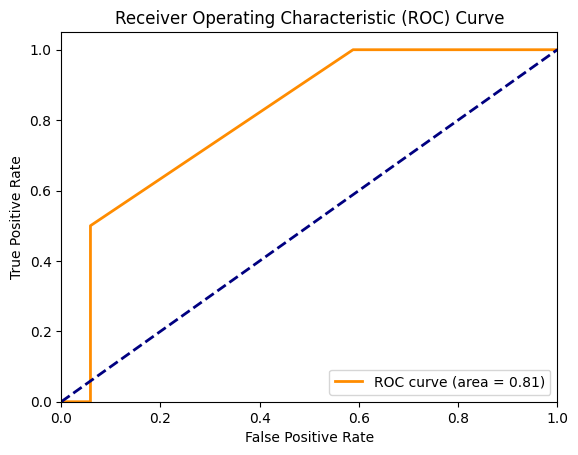


Decision Tree:
Accuracy: 0.9473684210526315
              precision    recall  f1-score   support

       Tesla       0.94      1.00      0.97        17
      Toyota       1.00      0.50      0.67         2

    accuracy                           0.95        19
   macro avg       0.97      0.75      0.82        19
weighted avg       0.95      0.95      0.94        19

Confusion matrix, without normalization
[[17  0]
 [ 1  1]]


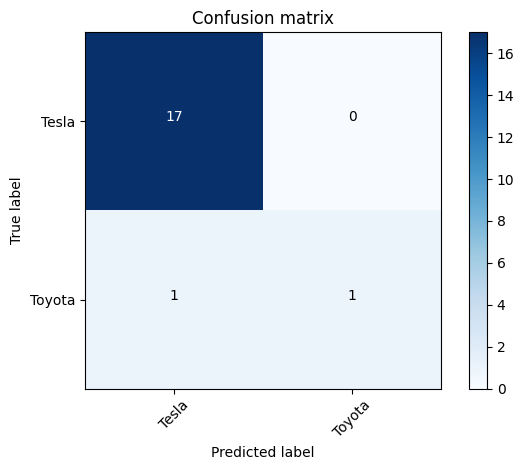

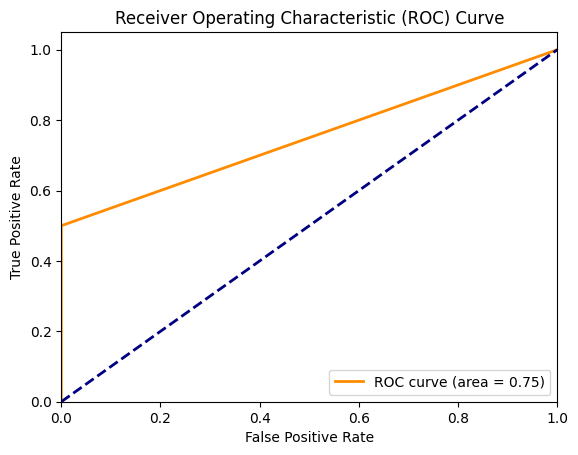


XGBoost:
Accuracy: 0.9473684210526315
              precision    recall  f1-score   support

       Tesla       0.94      1.00      0.97        17
      Toyota       1.00      0.50      0.67         2

    accuracy                           0.95        19
   macro avg       0.97      0.75      0.82        19
weighted avg       0.95      0.95      0.94        19

Confusion matrix, without normalization
[[17  0]
 [ 1  1]]


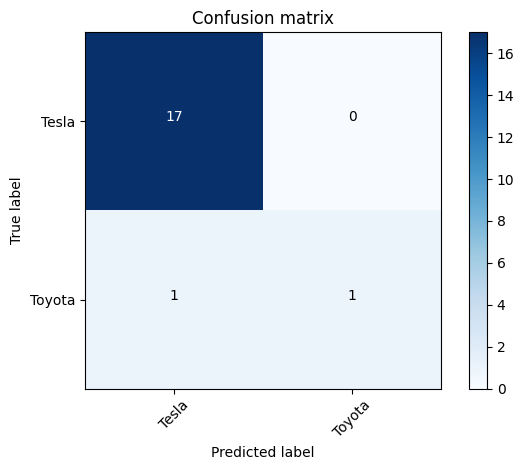

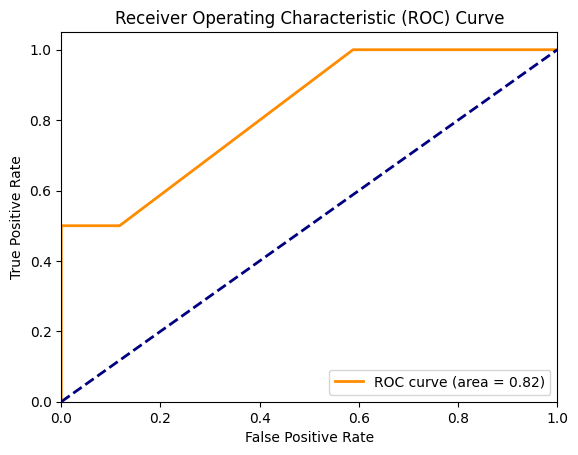

In [193]:
def preprocess_data(df):
    # Create a binary label for classification
    df['label'] = df['title'].apply(lambda x: 'Tesla' if 'tesla' in x.lower() else 'Toyota' if 'toyota' in x.lower() else None)
    # Drop rows where label is None
    df = df.dropna(subset=['label'])
    # Ensure all descriptions are strings and handle NaN values
    df['description'] = df['description'].fillna('').astype(str)
    return df

def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict probabilities on the test data
    y_pred_proba = model.predict_proba(X_test)
    # Predict on the test data
    y_pred = model.predict(X_test)
    # Print the accuracy and classification report
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred, target_names=['Tesla', 'Toyota']))
    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Tesla', 'Toyota'])
    plt.show()
    # Plot AUC-ROC curve
    plot_auc_roc_curve(y_test, y_pred_proba)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_auc_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define functions for each classifier
def logistic_regression(X_train, X_test, y_train, y_test):
    model = LogisticRegression()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def svm_classifier(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', probability=True)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def naive_bayes(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def knn_classifier(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def gradient_boosting(X_train, X_test,y_train, y_test):
    model = GradientBoostingClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def adaboost(X_train, X_test, y_train, y_test):
    model = AdaBoostClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def decision_tree(X_train, X_test, y_train, y_test):
    model = DecisionTreeClassifier(random_state=42)
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

def xgboost(X_train, X_test, y_train, y_test):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    train_and_evaluate(model, X_train, X_test, y_train, y_test)

# Preprocess the data
combined = preprocess_data(combined)

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Vectorize the description column
X = tfidf_vectorizer.fit_transform(combined['description'])

# Encode the labels (Tesla=0, Toyota=1)
y = combined['label'].apply(lambda x: 0 if x == 'Tesla' else 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train & evaluate using different models
print("Logistic Regression:")
logistic_regression(X_train, X_test, y_train, y_test)

print("\nSupport Vector Machine:")
svm_classifier(X_train, X_test, y_train, y_test)

print("\nRandom Forest:")
random_forest(X_train, X_test, y_train, y_test)

print("\nNaive Bayes:")
naive_bayes(X_train, X_test, y_train, y_test)

print("\nK-Nearest Neighbors:")
knn_classifier(X_train, X_test, y_train, y_test)

print("\nGradient Boosting:")
gradient_boosting(X_train, X_test, y_train, y_test)

print("\nAdaBoost:")
adaboost(X_train, X_test, y_train, y_test)

print("\nDecision Tree:")
decision_tree(X_train, X_test, y_train, y_test)

print("\nXGBoost:")
xgboost(X_train, X_test, y_train, y_test)